In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Goal**


*   Implement Denoising Diffusion Probabilistic Models in Pytorch.[DDPM paper](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html)
*   Train it on MNIST Data.
*   Generate New Images using trained diffusion Model.
*   Performance Evaluation (the evaluation of the quality of the generated data).

**Diffusion Model - The Intuition**

A diffusion model learns to transform a simple Normal Distribution into a complex one that represents images like cats, dogs, or churches. By learning this transformation, the model can generate new images by drawing samples from the Normal Distribution and mapping them to the complex image distribution it has learned. The goal is to master this transformation process so that the model can create realistic images from random noise.

**Diffusion Model - The Structure**


*   Forward Process
*   Reverse Process



**Forward Process: (Complex => Simple)**

The Forward Process gradually transforms the image into a Normal Distribution by introducing noise over T time steps.


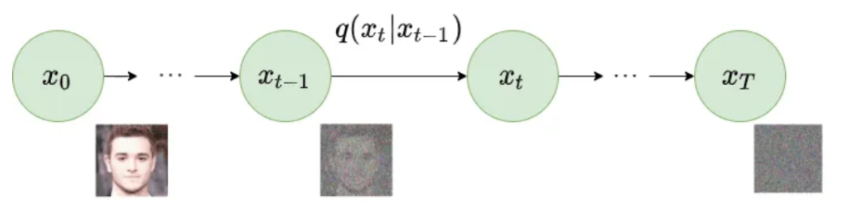

**Forward Diffusion Process Implementation**




*   The author adds the noise gradually according to the below Gaussian Distribution. Note that the noise is controlled by the parameter βt.

q
(
x
t
|
x
t
−
1
)
:=
N
(
x
t
;
√
(
1
−
β
t
)
x
t
−
1
,
β
t
I
)
 where
β
t
<
1
 for all
t
*   For forward process, Author opts for the below configuration:

Time steps (T) = 1000

β1 = 10-4 and βT = 0.02


β is linearly scheduled which means βt = β1 + (βT x (t-1))/T





*   The interesting thing to note here is that given input image x0 and βt's, we can precompute all xt's at once.


(
x
t
|
x
0
)
=
N
(
x
t
;
√
¯
α
t
x
0
,
(
1
−
¯
α
t
)
I
)

where




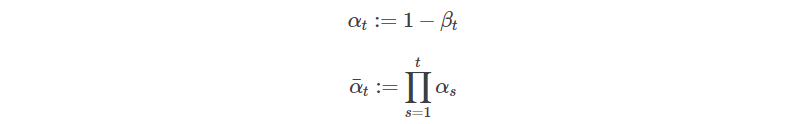


*   Using Reparameterization Trick; xt for all time steps can be computed using below formula

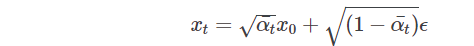



*  Note that there are no trainable parameter involved in the forward process.




In [2]:
!pip install scipy==1.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [3]:
import torch
import torch.nn as nn

In [4]:
class DiffusionForwardProcess:

    # Forward Process class as described in the
    # paper "Denoising Diffusion Probabilistic Models"

    def __init__(self,
                 num_time_steps = 1000,
                 beta_start = 1e-4,
                 beta_end = 0.02
                ):

        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)

    def add_noise(self, original, noise, t):
      # Adds noise to a batch of original images at time-step t.

      #   :param original: Input Image Tensor
      #   :param noise: Random Noise Tensor sampled from Normal Dist N(0, 1)
      #   :param t: timestep of the forward process of shape -> (B, )

      #   Note: time-step t may differ for each image inside the batch.

        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]

        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]

        # Return
        return (sqrt_alpha_bar_t * original) \
                           + \
               (sqrt_one_minus_alpha_bar_t * noise)

In [5]:
# Test
original = torch.randn(4, 1, 28, 28)
noise = torch.randn(4, 1, 28, 28)
t_steps = torch.randint(0, 1000, (4,))

# Forward Process
dfp = DiffusionForwardProcess()
out = dfp.add_noise(original, noise, t_steps)
out.shape

torch.Size([4, 1, 28, 28])

**Reverse Process: (Simple => Complex)**

Reverse process can be think of as a Inverse of the Forward Process.
The Goal of the reverse process is to gradually denoise the noisy image xT ~ N(0, 1) in T time steps.


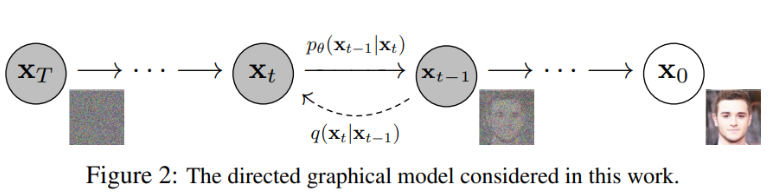



*   In Reverse Process; the image xt-1 is obtained from xt using below formulation. Note that the noise etheta is predicted by the model (U-net) which we will implement in the next section.


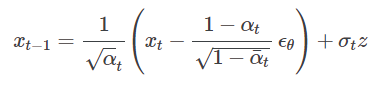

Where

z
∼
N
(
0
,
I
)


*  Also at each time-step, original image x0 can be predicted using below formula.


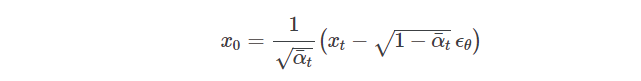

In [6]:
import torch

class DiffusionReverseProcess:
    # Reverse Process class as described in the
    # paper "Denoising Diffusion Probabilistic Models".

    # This class handles the reverse diffusion process, generating samples
    # from noise by gradually denoising step-by-step from time T to time 0.

    def __init__(self, num_time_steps=1000, beta_start=1e-4, beta_end=0.02):

        self.b = torch.linspace(beta_start, beta_end, num_time_steps)
        self.a = 1 - self.b
        self.a_bar = torch.cumprod(self.a, dim=0)

    def sample_prev_timestep(self, xt, noise_pred, t):

        # Sample x_(t-1) given x_t and noise predicted by the model.
        # :param xt: Image tensor at timestep t (current state) of shape -> (B, C, H, W)
        # :param noise_pred: Noise predicted by the model of shape -> (B, C, H, W)
        # :param t: Current time step (int)
        # :return: Tuple (mean of x_(t-1), original image x0) for t > 0,
        #          otherwise only returns the mean without noise addition.


        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0 / torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1., 1.)

        mean = (xt - ((1 - self.a.to(xt.device)[t]) * noise_pred) / (torch.sqrt(1 - self.a_bar.to(xt.device)[t])))
        mean = mean / (torch.sqrt(self.a.to(xt.device)[t]))


        if t == 0:
            return mean, x0

        else:
            variance = (1 - self.a_bar.to(xt.device)[t-1]) / (1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]

            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0


In [7]:
# Test
original = torch.randn(1, 1, 28, 28)
noise_pred = torch.randn(1, 1, 28, 28)
t = torch.randint(0, 1000, (1,))

# Forward Process
drp = DiffusionReverseProcess()
out, x0 = drp.sample_prev_timestep(original, noise_pred, t)
out.shape

torch.Size([1, 1, 28, 28])

**Model Architecture**


A U-net architecture is used to predict the noise.
U-net takes noisy image at time-step T and time-step T as input and returns the predicted noise which will be used to predict xt-1 and x0.



**Time Embedding**



*   In Diffusion model, Time information is important. The model needs to be aware of the specific time step at which it is predicting noise.
*   The idea to embed the time information is taken from the positional time embedding used in the Transformers. The time embedding is done using below formula. d_embed is the embedding dimension.




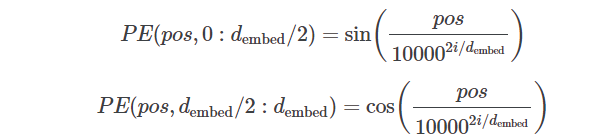

In [8]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:

    # Transform a scalar time-step into a vector representation of size t_emb_dim.

    # :param time_steps: 1D tensor of size -> (Batch,)
    # :param t_emb_dim: Embedding Dimension -> for ex: 128 (scalar value)

    # :return tensor of size -> (B, t_emb_dim)

    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."

    factor = 2 * torch.arange(start = 0,
                              end = t_emb_dim//2,
                              dtype=torch.float32,
                              device=time_steps.device
                             ) / (t_emb_dim)

    factor = 10000**factor

    t_emb = time_steps[:,None] # B -> (B, 1)
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)

    return t_emb


**U-net**


*   Diffusion Model predicts the amount of noise given noisy image at different time-steps.

*   Note that Input and Output both are 2-Dimensional images, Hence U-net type architecture is suitable for this task.
*   The U-net architecture begins by taking an image as input. It then proceeds to extract features while downsampling, followed by refining these downsampled features. Finally, it upsamples the refined features to reconstruct an image of the same size as the output.


*   U-net architecture consists of 3 main blocks.

*   Down-Convolutional Block
*   Mid-Conv Block
*   Up-Conv Block

A typical U-net block looks something like this.






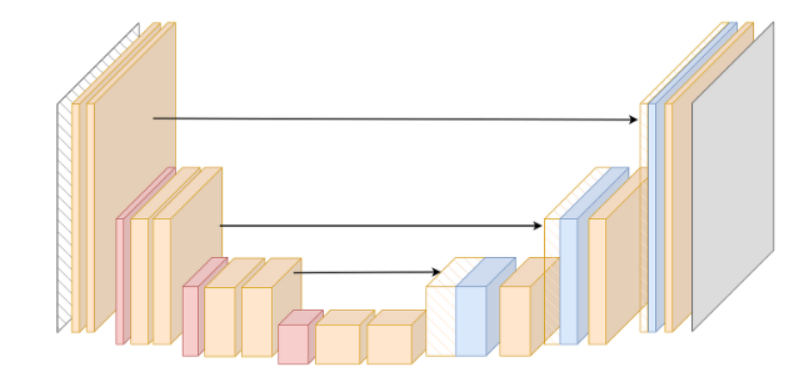

**Utility Module**

In [9]:
class NormActConv(nn.Module):
    #Perform GroupNorm, Activation, and Convolution operations.
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 num_groups:int = 8,
                 kernel_size: int = 3,
                 norm:bool = True,
                 act:bool = True
                ):
        super(NormActConv, self).__init__()

        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            in_channels
        ) if norm is True else nn.Identity()

        # Activation
        self.act = nn.SiLU() if act is True else nn.Identity()

        # Convolution
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size - 1)//2
        )

    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x

#-----------------------------------------------------------------
class TimeEmbedding(nn.Module):
    #Maps the Time Embedding to the Required output Dimension.
    def __init__(self,
                 n_out:int, # Output Dimension
                 t_emb_dim:int = 128 # Time Embedding Dimension
                ):
        super(TimeEmbedding, self).__init__()

        # Time Embedding Block
        self.te_block = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, n_out)
        )

    def forward(self, x):
        return self.te_block(x)

#---------------------------------------------------------------
class SelfAttentionBlock(nn.Module):
    #Perform GroupNorm and Multiheaded Self Attention operation.
    def __init__(self,
                 num_channels:int,
                 num_groups:int = 8,
                 num_heads:int = 4,
                 norm:bool = True
                ):
        super(SelfAttentionBlock, self).__init__()

        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            num_channels
        ) if norm is True else nn.Identity()

        # Self-Attention
        self.attn = nn.MultiheadAttention(
            num_channels,
            num_heads,
            batch_first=True
        )

    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x

#----------------------------------------------------------------

class Downsample(nn.Module):
    # Perform Downsampling by the factor of k across Height and Width.
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 k:int = 2, # Downsampling factor
                 use_conv:bool = True, # If Downsampling using conv-block
                 use_mpool:bool = True # If Downsampling using max-pool
                ):
        super(Downsample, self).__init__()

        self.use_conv = use_conv
        self.use_mpool = use_mpool

        # Downsampling using Convolution
        self.cv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_mpool else out_channels,
                kernel_size=4,
                stride=k,
                padding=1
            )
        ) if use_conv else nn.Identity()

        # Downsampling using Maxpool
        self.mpool = nn.Sequential(
            nn.MaxPool2d(k, k),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        ) if use_mpool else nn.Identity()

    def forward(self, x):

        if not self.use_conv:
            return self.mpool(x)

        if not self.use_mpool:
            return self.cv(x)

        return torch.cat([self.cv(x), self.mpool(x)], dim=1)

#-----------------------------------------------------------------------
class Upsample(nn.Module):
    # Perform Upsampling by the factor of k across Height and Width
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 k:int = 2, # Upsampling factor
                 use_conv:bool = True, # Upsampling using conv-block
                 use_upsample:bool = True # Upsampling using nn.upsample
                ):
        super(Upsample, self).__init__()

        self.use_conv = use_conv
        self.use_upsample = use_upsample

        # Upsampling using conv
        self.cv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels//2 if use_upsample else out_channels,
                kernel_size=4,
                stride=k,
                padding=1
            ),
            nn.Conv2d(
                out_channels//2 if use_upsample else out_channels,
                out_channels//2 if use_upsample else out_channels,
                kernel_size = 1,
                stride=1,
                padding=0
            )
        ) if use_conv else nn.Identity()

        # Upsamling using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(
                scale_factor=k,
                mode = 'bilinear',
                align_corners=False
            ),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        ) if use_upsample else nn.Identity()

    def forward(self, x):

        if not self.use_conv:
            return self.up(x)

        if not self.use_upsample:
            return self.cv(x)

        return torch.cat([self.cv(x), self.up(x)], dim=1)

In [10]:
layer = Upsample(16, 32, 2, True, True)
x = torch.randn(4, 16, 32, 32)
layer(x).shape

torch.Size([4, 32, 64, 64])

**Down-Conv Block**

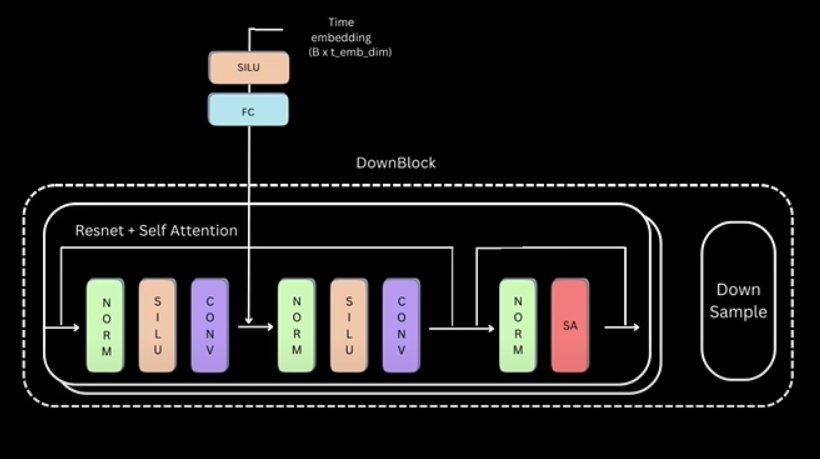

In [11]:
class DownC(nn.Module):
    # Perform Down-convolution on the input using following approach.
    # 1. Conv + TimeEmbedding
    # 2. Conv
    # 3. Skip-connection from input x.
    # 4. Self-Attention
    # 5. Skip-Connection from 3.
    # 6. Downsampling
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int=2,
                 down_sample:bool = True # True for Downsampling
                ):
        super(DownC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers)
        ])

    def forward(self, x, t_emb):

        out = x

        for i in range(self.num_layers):
            resnet_input = out

            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        # Downsampling
        out = self.down_block(out)

        return out

**Mid-conv Block**

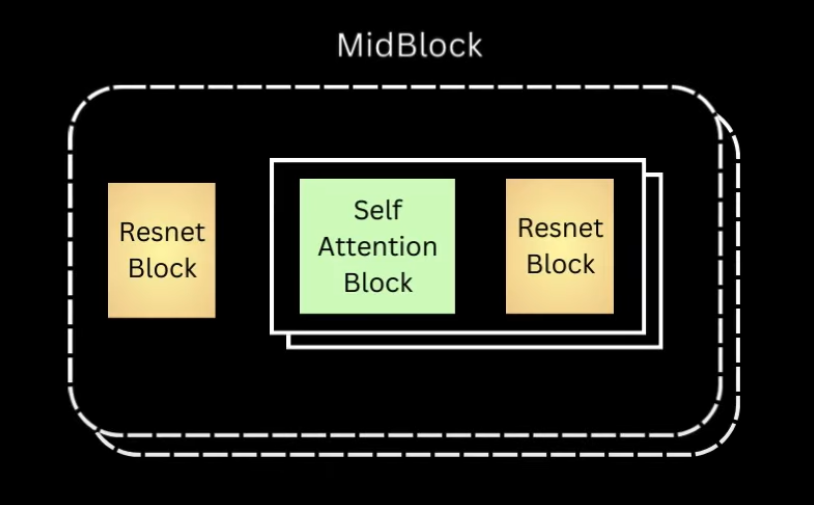

In [12]:
class MidC(nn.Module):
    # Refine the features obtained from the DownC block.
    # It refines the features using following operations:

    # 1. Resnet Block with Time Embedding
    # 2. A Series of Self-Attention + Resnet Block with Time-Embedding
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2
                ):
        super(MidC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers + 1)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers + 1)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])

    def forward(self, x, t_emb):
        out = x

        # First-Resnet Block
        resnet_input = out
        out = self.conv1[0](out)
        out = out + self.te_block[0](t_emb)[:, :, None, None]
        out = self.conv2[0](out)
        out = out + self.res_block[0](resnet_input)

        # Sequence of Self-Attention + Resnet Blocks
        for i in range(self.num_layers):

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

            # Resnet Block
            resnet_input = out
            out = self.conv1[i+1](out)
            out = out + self.te_block[i+1](t_emb)[:, :, None, None]
            out = self.conv2[i+1](out)
            out = out + self.res_block[i+1](resnet_input)

        return out

**Up-Conv Block**

In [13]:
class UpC(nn.Module):
    # Perform Up-convolution on the input using following approach.
    # 1. Upsampling
    # 2. Conv + TimeEmbedding
    # 3. Conv
    # 4. Skip-connection from 1.
    # 5. Self-Attention
    # 6. Skip-Connection from 3.
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int = 2,
                 up_sample:bool = True # True for Upsampling
                ):
        super(UpC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers)
        ])

    def forward(self, x, down_out, t_emb):

        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)

        out = x
        for i in range(self.num_layers):
            resnet_input = out

            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        return out

**U-Net**

Putting DownC, MidC, and UpC together to obtain the U-net.

In [14]:
class Unet(nn.Module):
    """
    U-net architecture which is used to predict noise
    in the paper "Denoising Diffusion Probabilistic Model".

    U-net consists of Series of DownC blocks followed by MidC
    followed by UpC.
    """

    def __init__(self,
                 im_channels: int = 1, # RGB
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2,
                 num_midc_layers:int = 2,
                 num_upc_layers:int = 2
                ):
        super(Unet, self).__init__()

        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers

        self.up_sample = list(reversed(self.down_sample)) # [False, True, True]

        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)

        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i],
                self.down_ch[i+1],
                self.t_emb_dim,
                self.num_downc_layers,
                self.down_sample[i]
            ) for i in range(len(self.down_ch) - 1)
        ])

        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i],
                self.mid_ch[i+1],
                self.t_emb_dim,
                self.num_midc_layers
            ) for i in range(len(self.mid_ch) - 1)
        ])

        # UpC Block
        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i],
                self.up_ch[i+1],
                self.t_emb_dim,
                self.num_upc_layers,
                self.up_sample[i]
            ) for i in range(len(self.up_ch) - 1)
        ])

        # Final Convolution
        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]),
            nn.Conv2d(self.up_ch[-1], self.im_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t):

        out = self.cv1(x)

        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        # DownC outputs
        down_outs = []

        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)

        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)

        # UpC Blocks
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)

        # Final Conv
        out = self.cv2(out)

        return out

In [15]:
# Test
model = Unet()
x = torch.randn(4, 1, 32, 32)
t = torch.randint(0, 10, (4,))
model(x, t).shape

torch.Size([4, 1, 32, 32])

In [16]:
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data.dataset import Dataset

class CustomMnistDataset(Dataset):

    #Reads the MNIST data from csv file given file path.

    def __init__(self, csv_path, num_datapoints = None):
        super(CustomMnistDataset, self).__init__()

        self.df = pd.read_csv(csv_path)

        # Will be useful later while evaluating
        if num_datapoints is not None:
            self.df = self.df.iloc[0:num_datapoints]

    def __len__(self):
        return len(self.df)

    def  __getitem__(self, index):
        # Read
        img = self.df.iloc[index].filter(regex='pixel').values
        img =  np.reshape(img, (28, 28)).astype(np.uint8)
        # Convert to Tensor
        img_tensor = torchvision.transforms.ToTensor()(img) # [0, 1]
        img_tensor = 2*img_tensor - 1 # [-1, 1]

        return img_tensor

**Training**

Dataset

In [19]:
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data.dataset import Dataset

class CustomMnistDataset(Dataset):
    def __init__(self, csv_path, num_datapoints = None):
        super(CustomMnistDataset, self).__init__()

        self.df = pd.read_csv(csv_path)

        # Will be useful later while evaluating
        if num_datapoints is not None:
            self.df = self.df.iloc[0:num_datapoints]

    def __len__(self):
        return len(self.df)

    def  __getitem__(self, index):
        # Read
        img = self.df.iloc[index].filter(regex='pixel').values
        img =  np.reshape(img, (28, 28)).astype(np.uint8)

        # Convert to Tensor
        img_tensor = torchvision.transforms.ToTensor()(img) # [0, 1]
        img_tensor = 2*img_tensor - 1 # [-1, 1]

        return img_tensor

In [20]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class CONFIG:
    model_path = 'ddpm_unet.pth'
    train_csv_path = '/content/drive/MyDrive/digit-recognizer/train.csv'
    test_csv_path = '/content/drive/MyDrive/digit-recognizer/test.csv'
    generated_csv_path = 'mnist_generated_data.csv'
    num_epochs = 2
    lr = 1e-4
    num_timesteps = 1000
    batch_size = 128
    img_size = 28
    in_channels = 1
    num_img_to_generate = 256


In [21]:
# Define your training function
def train(cfg):

    # Dataset and Dataloader with a limit of 1000 images
    mnist_ds = CustomMnistDataset(cfg.train_csv_path)
    mnist_dl = DataLoader(mnist_ds, cfg.batch_size, shuffle=True)

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')

    # Initiate Model
    model = Unet().to(device)

    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = torch.nn.MSELoss()

    # Diffusion Forward Process to add noise
    dfp = DiffusionForwardProcess()

    # Best Loss
    best_eval_loss = float('inf')

    # Train
    for epoch in range(cfg.num_epochs):

        # For Loss Tracking
        losses = []

        # Set model to train mode
        model.train()

        # Loop over dataloader
        for imgs in tqdm(mnist_dl):

            imgs = imgs.to(device)

            # Generate noise and timestamps
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, cfg.num_timesteps, (imgs.shape[0],)).to(device)

            # Add noise to the images using Forward Process
            noisy_imgs = dfp.add_noise(imgs, noise, t)

            # Avoid Gradient Accumulation
            optimizer.zero_grad()

            # Predict noise using U-net Model
            noise_pred = model(noisy_imgs, t)

            # Calculate Loss
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())

            # Backprop + Update model params
            loss.backward()
            optimizer.step()

        # Mean Loss
        mean_epoch_loss = np.mean(losses)

        # Display
        print('Epoch:{} | Loss : {:.4f}'.format(
            epoch + 1,
            mean_epoch_loss,
        ))
        # Save based on train-loss
        if mean_epoch_loss < best_eval_loss:
            best_eval_loss = mean_epoch_loss
            torch.save(model, cfg.model_path)

    print(f'Done training.....')

# Call the train function with CONFIG
train(CONFIG)


Device: cuda



100%|██████████| 329/329 [03:53<00:00,  1.41it/s]


Epoch:1 | Loss : 0.1702


100%|██████████| 329/329 [03:49<00:00,  1.43it/s]

Epoch:2 | Loss : 0.0625
Done training.....


**Image Generation/Inference**

In [22]:
def generate(cfg):
    # Given Pretrained DDPM U-net model, Generate Real-life
    # Images from noise by going backward step by step. i.e.,
    # Mapping of Random Noise to Real-life images.

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(f'Device: {device}\n')

    # Initialize Diffusion Reverse Process
    drp = DiffusionReverseProcess()

    # Set model to eval mode
    model = torch.load(cfg.model_path).to(device)
    model.eval()

    # Generate Noise sample from N(0, 1)
    xt = torch.randn(1, cfg.in_channels, cfg.img_size, cfg.img_size).to(device)


    # Denoise step by step by going backward.
    with torch.no_grad():
        for t in reversed(range(cfg.num_timesteps)):
            noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))
            xt, x0 = drp.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))

    # Convert the image to proper scale
    xt = torch.clamp(xt, -1., 1.).detach().cpu()
    xt = (xt + 1) / 2

    return xt

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-22-795a0ca9dc46>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(cfg.model_path).to(device)
100%|███

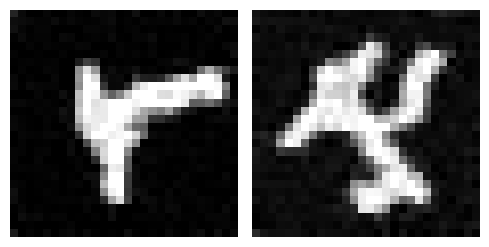

In [25]:
# Load model and config
cfg = CONFIG()

# Generate
generated_imgs = []
for i in tqdm(range(2)):
    xt = generate(cfg)
    xt = 255 * xt[0][0].numpy()
    generated_imgs.append(xt.astype(np.uint8).flatten())

# Save Generated Data CSV
generated_df = pd.DataFrame(generated_imgs, columns=[f'pixel{i}' for i in range(784)])
generated_df.to_csv(cfg.generated_csv_path, index=False)

# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(np.reshape(generated_imgs[i], (28, 28)), cmap='gray')  # You might need to adjust the colormap based on your images
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

**Performance Evaluation**

Fréchet Inception Distance (FID) is used to evaluate the performance of the generated dataset.

FID compares the distribution of the generated samples with the distribution of the real images (ground truth). In simple terms, it provides a measure of the statistical closeness between generated data and real data.

It uses Pretrained Inception net to get the last 1-D activation maps of the images for a set of both generated and real images. then it fits the gaussian distribution on both datasets. Finally, it computes the distance between the two Gaussian distributions using the 2-Wasserstein distance, also known as the FID (Fréchet Inception Distance), according to the following formula.

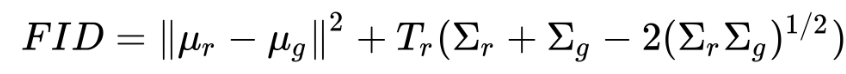

In [26]:
def get_activation(dataloader,
                   model,
                   preprocess, # Preprocessing Transform for InceptionV3
                   device = 'cpu'
                  ):

    # Set model to evaluation Mode
    model.to(device)
    model.eval()

    # Save activations
    pred_arr = np.zeros((len(dataloader.dataset), 2048))

    # Batch Size
    batch_size = dataloader.batch_size

    # Loop over Dataloader
    with torch.no_grad():
      for i, batch in tqdm(enumerate(dataloader)):

            # Transform the Batch according to Inceptionv3 specification
            batch = torch.stack([preprocess(img) for img in batch]).to(device)

            # Predict
            pred = model(batch).cpu().numpy()

            # Store
            pred_arr[i*batch_size : i*batch_size + batch.size(0), :] = pred

    return pred_arr

#--------------------------------------------------------------------
def calculate_activation_statistics(dataloader,
                                    model,
                                    preprocess,
                                    device='cpu'
                                   ):
    # Get mean vector and covariance matrix of the activation maps.
    # Get activation maps
    act = get_activation(dataloader,
                         model,
                         preprocess, # Preprocessing Transform for InceptionV3
                         device
                       )
    # Mean
    mu = np.mean(act, axis=0)

    # Covariance Metric
    sigma = np.cov(act, rowvar=False)

    return mu, sigma

#--------------------------------------------------------------------

from scipy import linalg

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):

    # Given Mean and Sigma of Real and Generated Data,
    # it calculates FID between them using:
    #  d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    # Make sure they have appropriate dims
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle various cases
    if not np.isfinite(covmean).all():
        msg = (
            "fid calculation produces singular product; "
            "adding %s to diagonal of cov estimates"
        ) % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

**Evaluation**

In [27]:
# Transform to Convert Output of CustomMnistDataset class to Inception format.
import torchvision.transforms as transforms

transform_inception = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1.0)/2.0), # [-1, 1] => [0, 1]
    transforms.ToPILImage(), # Tensor to PIL Image
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization

])

# Load InceptionV3 Model
import torchvision.models as models
from torchvision.models.inception import Inception_V3_Weights
model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
model.fc = nn.Identity()

# Mean and Sigma For Generated Data
mnist_ds = CustomMnistDataset(cfg.generated_csv_path, cfg.num_img_to_generate)
mnist_dl = DataLoader(mnist_ds, cfg.batch_size//4, shuffle=False)
mu1, sigma1 = calculate_activation_statistics(mnist_dl, model, preprocess = transform_inception, device='cuda')

# Mean and Sigma for Test Data
mnist_ds = CustomMnistDataset(cfg.test_csv_path, cfg.num_img_to_generate)
mnist_dl = DataLoader(mnist_ds, cfg.batch_size//4, shuffle=False)
mu2, sigma2 = calculate_activation_statistics(mnist_dl, model, preprocess = transform_inception, device='cuda')

# Calculate FID
fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
print(f'FID-Score: {fid}')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 53.6MB/s]
1it [00:00,  5.07it/s]
8it [00:01,  4.19it/s]


FID-Score: 338.10962007012637


 FID Score of 338.10 by evaluating on just 256 images and iterating only by 2 epochs. Optimally we should evaluate on a higher number of samples and higher number of epochs to get a good measure of generated samples.